<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/interactive_notebooks/Offline_AL_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Offline AL Relaxation Demo
Using the proposed offline acitve learning framework to accelearte a structure relaxation of C/Cu (100). EMT is used for performance but the option to use DFT through Qunatum ESpresso is also available. If interested in the results presented in the paper see https://github.com/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/tree/master/terminal_scripts.

###Installations and Imports

In [1]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics

     |████████████████████████████████| 296kB 5.5MB/s 
     |████████████████████████████████| 6.7MB 9.8MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 2.2MB 52.9MB/s 
     |████████████████████████████████| 12.8MB 243kB/s 
     |████████████████████████████████| 110.5MB 37kB/s 
     |████████████████████████████████| 3.8MB 48.5MB/s 
     |████████████████████████████████| 512kB 42.2MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatib

In [2]:
# Installation for QE-DFT
!pip install -q --upgrade dftbook
import dftbook
dftbook.setup_colab()
from espresso import Espresso

Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 22.5 seconds


In [11]:
import sys
import numpy as np
import random
import torch
import copy

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import BFGS, BFGSLineSearch
from ase.eos import EquationOfState
from ase.build import bulk
from ase import Atoms, Atom

from amptorch.active_learning.atomistic_methods import MDsimulate, Relaxation
from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, final_max_query, final_query
from amptorch.active_learning.al_utils import progressive_plot
from amptorch.model import CustomMSELoss

import multiprocessing as mp
try:
  mp.set_start_method("spawn")
except:
  if mp.get_start_method() == "spawn":
    pass
  else:
    raise Exception('Wrong mp start method!')

### Define parent calculator
Specify ASE calculator. EMT will be used for the demo for the sake of time. Note - A GPU version of QE is installed and is only compatible with some of the newer cards. If you get an error using QE try restarting the runtime for a better card (Colab Pro users don't encounter this issue). 

In [4]:
emt_calc = EMT()
dft_calc = Espresso(
    pw=500.0, 
    calculation='scf',
    kpts=(4,4,1),
    xc='PBE'
)

base_calc = emt_calc

### Create structure to relax: C/Cu(100)


In [5]:
energies = []
volumes = []
LC = [3.5, 3.55, 3.6, 3.65, 3.7, 3.75]

for a in LC:
  cu_bulk = bulk('Cu', 'fcc', a=a)

  calc = base_calc

  cu_bulk.set_calculator(copy.copy(base_calc))

  e = cu_bulk.get_potential_energy()
  energies.append(e)
  volumes.append(cu_bulk.get_volume())


eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
aref=3.6
vref = bulk('Cu', 'fcc', a=aref).get_volume()

copper_lattice_constant = (v0/vref)**(1/3)*aref

slab = fcc100("Cu", a=copper_lattice_constant, size=(2, 2, 3))
ads = molecule("C")
add_adsorbate(slab, ads, 3, offset=(1, 1))
cons = FixAtoms(
    indices=[atom.index for atom in slab if (atom.tag == 3)]
)
slab.set_constraint(cons)
slab.center(vacuum=13.0, axis=2)
slab.set_pbc([True, True, False])
slab.wrap(pbc=[True, True, False])
slab.set_initial_magnetic_moments()

In [6]:
#Construct initial training data
slab.set_calculator(copy.copy(base_calc))
slab_energy = slab.get_potential_energy(apply_constraint=False)
slab_forces = slab.get_forces(apply_constraint=False)
slab.set_calculator(sp(slab, energy=slab_energy, forces=slab_forces))
training_images = [slab] 

###Define model parameters and settings for ML+Morse run

Modify the following arguments to explore the alternative query strategies:

- Random: 

  ```
  "al_convergence": {"method": "iter", "num_iterations": 20},
  "samples_to_retrain": 1,
  ```
  ```
  ensemble=False
  query_strategy=random_query
  ```

- Quasi-Random:
  ```
  "al_convergence": {"method": "final", "force_tol": 0.05},
  "samples_to_retrain": 1,
  ```
  ```
  ensemble=False
  query_strategy=final_query
  ```

- Uncertainty:
  ```
  "al_convergence": {"method": "final", "force_tol": 0.05},
  "samples_to_retrain": 1,
  ```
  ```
  ensemble=3 
  query_strategy=final_max_query
  ```
  
  *note - Google Colab is limited to 2 CPUs so this may not be efficiently parallelized here.

In [12]:
def main():
  # Define symmetry functions
  Gs = {}
  Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
  Gs["G2_rs_s"] = [0] * 4
  Gs["G4_etas"] = [0.005]
  Gs["G4_zetas"] = [1.0, 4.0]
  Gs["G4_gammas"] = [+1.0, -1]
  Gs["cutoff"] = 6.0

  training_params = {
        "al_convergence": {"method": "final", "force_tol": 0.05},
        "samples_to_retrain": 1,
        "Gs": Gs,
        "morse": True,
        "forcetraining": True,
        "cores": 10,
        "optimizer": torch.optim.LBFGS,
        "batch_size": 1000,
        "criterion": CustomMSELoss,
        "num_layers": 3,
        "num_nodes": 20,
        "force_coefficient": 0.04,
        "learning_rate": 1e-1,
        "epochs": 300,
        "test_split": 0,
        "shuffle": False,
        "verbose": 1,
        "filename": "example",
        "file_dir": "./",
        "scheduler": {
            "policy": "CosineAnnealingWarmRestarts",
            "params":{"T_0":10, "T_mult":2}
        }
  }
  # Define AL scheme
  learner = AtomisticActiveLearner(
      training_data=training_images,
      training_params=training_params,
      parent_calc=base_calc,
      ensemble=False,
  )

  # Learn the corresponding atomistic method
  learner.learn(
      atomistic_method=Relaxation(
          initial_geometry=slab,
          optimizer=BFGS,
          fmax=0.05,
          steps=100,
      ),
      query_strategy=final_query,
  )

In [13]:
if __name__ == "__main__":
  main()

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0077          3.8914        0.3029     +  0.0662
      2          0.0191          0.5197        0.0056     +  0.0826
      3          0.0057          0.1506        0.0005     +  0.0879


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      4          0.0019          0.0577        0.0001     +  0.1065
      5          0.0006          0.0283        0.0000     +  0.1219
      6          0.0002          0.0164        0.0000     +  0.1199
      7          0.0000          0.0099        0.0000     +  0.1190
      8          0.0000          0.0068        0.0000     +  0.1197
      9          0.0000          0.0054        0.0000     +  0.1167
     10          0.0000          0.0047        0.0000     +  0.1207
     11          0.0000          0.0045        0.0000     +  0.0143
     12          0.0000          0.0045        0.0000     +  0.0133
     13          0.0000          0.0045        0.0000        0.1225
     14          0.0000          0.0029        0.0000     +  0.1227
     15          0.0000          0.0025        0.0000     +  0.0111
     16          0.0000          0.0024        0.0000     +  0.0114
     17          0.0000          0.0024        0.0000     +  0.0131
     18          0.0000          0.0024        0

### Compute parent calculator relaxation

In [14]:
# Compute the parent calculator (DFT) based relaxation
true_relax = Relaxation(slab, BFGS, fmax=0.05)
true_relax.run(base_calc, 'true_relax')

      Step     Time          Energy         fmax
BFGS:    0 22:40:48        6.115958        1.2949
BFGS:    1 22:40:48        6.074985        1.3456
BFGS:    2 22:40:49        5.572582        1.9434
BFGS:    3 22:40:49        4.922707        2.4287
BFGS:    4 22:40:49        4.259664        1.9156
BFGS:    5 22:40:49        4.287871        3.2775
BFGS:    6 22:40:49        4.111370        1.0796
BFGS:    7 22:40:49        4.084050        0.6715
BFGS:    8 22:40:49        4.062120        0.8868
BFGS:    9 22:40:49        4.040960        1.0517
BFGS:   10 22:40:49        3.927401        1.2896
BFGS:   11 22:40:49        3.887083        0.6724
BFGS:   12 22:40:49        3.851547        0.4864
BFGS:   13 22:40:49        3.814668        0.5876
BFGS:   14 22:40:49        3.780212        0.6861
BFGS:   15 22:40:49        3.756034        0.4885
BFGS:   16 22:40:49        3.746017        0.1903
BFGS:   17 22:40:49        3.743799        0.1797
BFGS:   18 22:40:49        3.741488        0.1598
B

###Visualization/Metrics

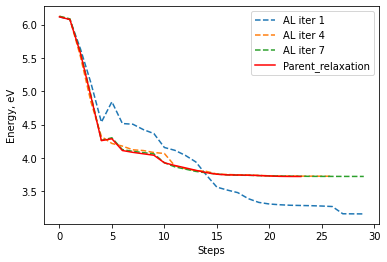

In [30]:
# Visualize Results
import matplotlib
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import mean_squared_error
%matplotlib inline

iters = len(glob.glob("example_*.traj"))
parent_calc_traj = ase.io.read('true_relax.traj', ':')
#Compute actual energies for parent relaxation structures
parent_relaxation_energies = [image.get_potential_energy() for image in parent_calc_traj]
parent_steps = range(len(parent_calc_traj))

for i in range(1, iters, 3):
  final_ml_traj = ase.io.read(f"example_iter_{i}.traj", ":")

  #Compute ML predicted energies
  ml_relaxation_energies = [image.get_potential_energy() for image in final_ml_traj]

  ml_steps = range(len(final_ml_traj))
  plt.plot(ml_steps, ml_relaxation_energies, ls='--', label=f'AL iter {i}')

plt.plot(parent_steps, parent_relaxation_energies, '-r', label='Parent_relaxation')
plt.xlabel("Steps")
plt.ylabel("Energy, eV")
plt.legend()
plt.show()

In [37]:
# Evaluation Metrics
def structure_mae(a, b):
  pos_a = a.positions
  pos_b = b.positions
  return np.mean(np.sum(np.abs(pos_a - pos_b), axis=1))

def energy_mae(a, b):
  energy_a = a.get_potential_energy(apply_constraint=False)
  energy_b = b.get_potential_energy(apply_constraint=False)
  return np.mean(np.abs(energy_a-energy_b))

initial_structure = training_images[0]
queries = len(ase.io.read("example.db", ":"))

print(f'Number of AL iterations: {iters}')
print(f'Total # of parent queries: {queries}')

print(f'Final AL Relaxed Energy: {ml_relaxation_energies[-1]}\n')
al_relaxed_structure = final_ml_traj[-1]

print(f'Total number of DFT steps: {len(parent_relaxation_energies)}')
print(f'Final DFT Relaxed Energy: {parent_relaxation_energies[-1]}\n')
parent_relaxed_structure = parent_calc_traj[-1]

initial_structure_error = structure_mae(initial_structure, parent_relaxed_structure)
relaxed_structure_error = structure_mae(al_relaxed_structure, parent_relaxed_structure)
relaxed_energy_error = energy_mae(al_relaxed_structure, parent_relaxed_structure)

print(f'Initial structure error: {initial_structure_error}')
print(f'AL relaxed structure error: {relaxed_structure_error}')
print(f'AL relaxed energy error: {relaxed_energy_error}')

Number of AL iterations: 8
Total # of parent queries: 14
Final AL Relaxed Energy: 3.72279953956604

Total number of DFT steps: 24
Final DFT Relaxed Energy: 3.7221322748839345

Initial structure error: 0.1080427282663072
AL relaxed structure error: 0.006109262215606158
AL relaxed energy error: 0.0006672646821055395
